In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import model_selection
from sklearn.datasets import load_digits

# 1 Loading the Dataset

<span style="color:green;font-weight:bold">
Repeating the plots from FML is a good idea!
</span>

data.shape          = (1797, 64)
data.dtype          = float64
images.shape        = (1797, 8, 8)
images.shape        = float64
target.shape        = (1797,)
target.shape        = int64
target_names.shape  = (10,)
target_names.shape  = int64
target[:20]         = [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


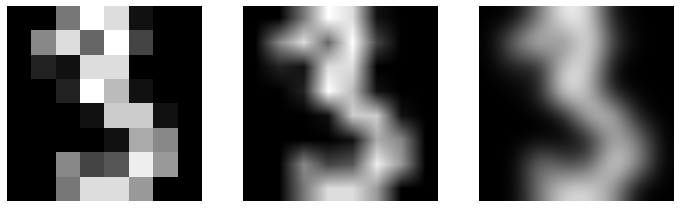

In [2]:
digits = load_digits()

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

print(f"data.shape          = {data.shape}")
print(f"data.dtype          = {data.dtype}")
print(f"images.shape        = {images.shape}")
print(f"images.shape        = {images.dtype}")
print(f"target.shape        = {target.shape}")
print(f"target.shape        = {target.dtype}")
print(f"target_names.shape  = {target_names.shape}")
print(f"target_names.shape  = {target_names.dtype}")
print(f"target[:20]         = {target[:20]}")

img = images[3, :, :]
assert 2 == len(img.shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)

axes[0].imshow(img, cmap="gray", interpolation="nearest")
axes[0].set_axis_off()

axes[1].imshow(img, cmap="gray", interpolation="bilinear")
axes[1].set_axis_off()

axes[2].imshow(img, cmap="gray", interpolation="bicubic")
axes[2].set_axis_off()

plt.show()

In [154]:
data_prep = data[np.where((target == 8) | (target == 3))]
data_prep = np.hstack((data_prep,np.ones((data_prep.shape[0],1))))


ground_truth = target[np.where((target == 8) | (target == 3))]
ground_truth[ground_truth == 3] = 1
ground_truth[ground_truth == 8] = -1


X, y = data_prep, ground_truth
print(X.shape, y.shape)

(357, 65) (357,)


# 1.1 Classification with sklearn

<span style="color:green;font-weight:bold">
You only tried very few options for $\lambda$.


A plot could also have served as guidance for whether
you've explored the limits of hyper-parameter
optimization. Luckily for you, you included a
value close to the optimal $\lambda$ here.

You used linear spacing for the values of $\lambda$, which is fine.
However, logarithmic spacing can allow you to try vastly
greater ranges of hyperparameters without being
prohibitively calculation intensive.

Good job using `GridSearch` instead of a python loop.
</span>


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

log_reg = LogisticRegression(max_iter=250)
c_val_to_try_out = np.arange(0.1, 10, 0.1)

hyper_grid = dict(C=c_val_to_try_out)

grid_search = GridSearchCV(log_reg, hyper_grid).fit(X, y)
grid_search.best_params_

{'C': 0.30000000000000004}

# 1.2 Optimization Methods

<span style="color:green;font-weight:bold">
Looks fine.
</span>

In [71]:
# helper functions

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def gradient(beta, X, y, C=0.3):
    
    if len(X.shape) == 1:
        # for a single entry
        grad = beta + C * sigmoid(-y*(X @ beta)) * (-y*X.T)
    else:
        # for multiple rows
        grad = beta + (C/X.shape[0]) * np.sum(sigmoid(-y*(X @ beta)) * (-y*X.T), axis=1)

    return grad

<span style="color:green;font-weight:bold">
What about using `np.sign`? You could also cache the indices:

```
mask = threshold > 0
prediction[mask] = 1
prediction[~mask] = -1
```
</span>

In [ ]:
def predict(beta, X):
    threshold = beta @ X.T

    if len(X.shape) == 1:
        return 1 if threshold > 0 else -1
    
    prediction = np.zeros((X.shape[0]))
    prediction[threshold > 0] = 1
    prediction[threshold <= 0] = -1
    
    return prediction

<span style="color:green;font-weight:bold">
This works, but is computationally expensive. Something like

```
return (y_prediction != y_truth).sum()
```

or

```
return (0.5 * np.abs(y_prediction - y_truth)).sum()
```

is much cheaper.

</span>

In [ ]:
def zero_one_loss(y_prediction, y_truth):
    return np.sqrt(((y_prediction - y_truth) / 2)**2).sum()

def learning_rate(t, tau_0, decay):
    return tau_0 / (1 + t * decay)

<span style="color:green;font-weight:bold">
Good.
</span>

In [106]:
# gradient descent

def gradient_descent(X, y, beta_0, tau_0, decay, m):
    beta_t = beta_0
    for t in range(m):
        beta_t = beta_t - learning_rate(t, tau_0, decay) * gradient(beta_t, X, y)
    return beta_t

    
tau_0 = 0.01
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
beta_train = gradient_descent(X, y, beta_0, tau_0, decay, 1000)
zero_one_loss(predict(beta_train, X), y)

2.0

<span style="color:green;font-weight:bold">
Yes, there is no significant difference for this exercise. Sampling without replacement is
used more frequently in practice.
</span>

Sampling without replacement seems to make more intuitive sense, since every data point should ony count one time for the computation of the gradient. Although looking into the literature this seems to not be very clear cut...



<span style="color:green;font-weight:bold">
Good. You can supply `np.random.choice` with an integer instead of an array in this case, saving some memory.
</span>

In [136]:
# stochastic gradient descent

def stochastic_gradient_descent(X, y, beta_0, tau_0, decay, m):
    beta_t = beta_0
    
    for t in range(m):
        
        sample_idx = np.random.choice(np.arange(X.shape[0]), replace=False) 
        beta_t = beta_t - learning_rate(t, tau_0, decay) * gradient(beta_t, X[sample_idx], y[sample_idx])
    
    return beta_t

    
    
tau_0 = 0.01
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
beta_train = stochastic_gradient_descent(X, y, beta_0, tau_0, decay, 1000)
zero_one_loss(predict(beta_train, X), y)

1.0

<span style="color:green;font-weight:bold">
Good. Same comment on `np.random.choice` as above.
</span>

In [108]:
# stochastic gradient minibatch

def stochastic_gradient_minibatch(X, y, beta_0, tau_0, decay, B, m):
    beta_t = beta_0
    
    for t in range(m):
        
        sample_idx = np.random.choice(np.arange(X.shape[0]), size=B, replace=False)

        beta_t = beta_t - learning_rate(t, tau_0, decay) * gradient(beta_t, X[sample_idx], y[sample_idx])
    
    return beta_t

    
    
tau_0 = 0.01
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
B = 10
beta_train = stochastic_gradient_minibatch(X, y, beta_0, tau_0, decay, B, 1000)
zero_one_loss(predict(beta_train, X), y)

2.0

<span style="color:green;font-weight:bold">
Good.
</span>

In [140]:
# stochastic gradient momentum

def stochastic_gradient_momentum(X, y, beta_0, g_0, tau_0, decay, mu, m):
    
    beta_t = beta_0
    g_t = g_0
    
    for t in range(m):
        
        sample_idx = np.random.choice(np.arange(X.shape[0]), replace=False)
        
        g_t = mu * g_t + (1-mu) * gradient(beta_t, X[sample_idx], y[sample_idx])
        beta_t = beta_t - learning_rate(t, tau_0, decay) * g_t

    return beta_t

    
    
tau_0 = 0.01
decay = 0.01
beta_0, g_0 = np.zeros((X.shape[1])), np.zeros((X.shape[1]))
mu=0.9
beta_train = stochastic_gradient_momentum(X, y, beta_0, g_0, tau_0, decay, mu, 1000)
zero_one_loss(predict(beta_train, X), y)

0.0

<span style="color:green;font-weight:bold">
You should cache the gradient, since its computation is expensive.
Otherwise good. Prefer function parameters over hard-coded values.
</span>

In [133]:
# ADAM

def adam(X, y, beta_0, tau, decay, m):
    beta_t = beta_0
    mu_1, mu_2 = 0.9, 0.999
    eps = 10e-8
    
    g_t = 0
    q_t = 0
    
    for t in range(m):
        
        sample_idx = np.random.choice(np.arange(X.shape[0]), replace=False) 
        
        g_t = mu_1 * g_t + (1-mu_1) * gradient(beta_t, X[sample_idx], y[sample_idx])
        q_t = mu_2 * q_t + (1-mu_2) * (gradient(beta_t, X[sample_idx], y[sample_idx]) ** 2)
        
        g_bar_t = g_t / (1-mu_1)
        q_bar_t = q_t / (1-mu_2)
        
        beta_t = beta_t - tau * (1 / (np.sqrt(q_bar_t) + eps)) * g_bar_t
         
    
    return beta_t

        
tau = 10e-4
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
beta_train = adam(X, y, beta_0, tau, decay, 1000)
zero_one_loss(predict(beta_train, X), y)

1.0

<span style="color:green;font-weight:bold">
You can vectorize the computation of `g_stored` (see sample solution). Fine otherwise.
</span>

In [160]:
# stochastic average gradient

def stochastic_average_gradient(X, y, beta_0, tau_0, decay, m):
    
    C = 0.3
    beta_t = beta_0
    g_stored =  np.array([(sigmoid(-y[i]*(X[i] @ beta_t)) * (-y[i]*X[i].T)) for i, _ in enumerate(X)])
    g_t = np.mean(g_stored, axis=0)

    for t in range(m):
        
        sample_idx = np.random.choice(np.arange(X.shape[0]), replace=False)

        g_t_i = sigmoid(-y[sample_idx]*(X[sample_idx] @ beta_t)) * (-y[sample_idx]*X[sample_idx].T)
        
        g_t = g_t + (1 / (X.shape[0])) * (g_t_i - g_stored[sample_idx])
        g_stored[sample_idx] = g_t_i
        
        beta_t = beta_t * (1 - (learning_rate(t, tau_0, decay)/C)) - learning_rate(t, tau_0, decay)*g_t
        

    return beta_t


        
tau_0 = 0.01
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
beta_train = stochastic_average_gradient(X, y, beta_0, tau_0, decay, 1000)
zero_one_loss(predict(beta_train, X), y)

3.0

<span style="color:green;font-weight:bold">
Good.
</span>

In [184]:
# dual coordinate ascent

def dual_coordinate_ascent(X, y, beta_0, alpha_0, tau_0, decay, m):
    
    C = 0.3
    
    alpha_t = alpha_0

    beta_t = (C/X.shape[0]) * np.sum((alpha_t * y*X.T), axis=1)
    eps = 10e-4
    
    for t in range(m):

        sample_idx = np.random.choice(np.arange(X.shape[0]), replace=False)
        f_1 = y[sample_idx] * X[sample_idx] @ beta_t + np.log(alpha_t[sample_idx] / (1-alpha_t[sample_idx]))

        f_2 = (C / X.shape[0]) * X[sample_idx] @ X[sample_idx].T + 1 / (alpha_t[sample_idx]*(1-alpha_t[sample_idx]))

        alpha_t_i = alpha_t[sample_idx] - (f_1 / f_2)
        alpha_t_i = np.clip(alpha_t_i, eps, 1-eps)
        
        beta_t = beta_t + (C / X.shape[0]) * (-y[sample_idx]*X[sample_idx].T) * (alpha_t_i - alpha_t[sample_idx])
        
        alpha_t[sample_idx] = alpha_t_i
    return beta_t


        
tau_0 = 0.01
decay = 0.01
alpha_0 = np.random.uniform(size = X.shape[0])
beta_0 = np.zeros((X.shape[1]))
beta_train = dual_coordinate_ascent(X, y, beta_0, alpha_0, tau_0, decay, 1000)

<span style="color:green;font-weight:bold">
Good.
</span>


In [203]:
# Newton / Raphson

def newton_raphson(X, y, beta_0, tau_0, decay, m):
    
    C = 0.3
    beta_t = beta_0
    
    for t in range(m):
        z_t = X @ beta_t
        y_bar_t = y / (sigmoid(y*z_t))
        
        W = np.diag((C / X.shape[0]) * sigmoid(z_t) * sigmoid(-z_t))
        beta_t = np.linalg.inv((np.identity(X.shape[1]) + X.T@ W @ X)) @ X.T @ W @ (z_t + y_bar_t)

    return beta_t

    
    
tau_0 = 0.01
decay = 0.01
beta_0 = np.zeros((X.shape[1]))
beta_train = newton_raphson(X, y, beta_0, tau_0, decay, 1000)
zero_one_loss(predict(beta_train, X), y)

2.0

# 1.3 Comparison

In [212]:
from sklearn import model_selection

X, X_test, y, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

beta_0, g_0, alpha_0 = np.zeros((X.shape[1])), np.zeros((X.shape[1])), np.random.uniform(size=X.shape[1])

## Learning rate

<span style="color:green;font-weight:bold">
Good. You <i>can</i> do this with less code,
calling the individual optimizer functions in a loop,
with parameters passed by a dictionary / list
(which makes the code slightly more maintainable),
but it's a lot of effort for only a small improvement.
</span>


In [225]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=10)

TAU = [0.001, 0.01, 0.1]
MU = [0.1, 0.2, 0.5]
GAMMA = [0.0001, 0.001, 0.01]


grad_err, sg_err, sg_batch_err, sg_mom_err, adam_err, av_err, newton_err = np.zeros((3,3,3)), np.zeros((3,3,3)), \
np.zeros((3,3,3)), np.zeros((3,3,3)), np.zeros((3,3,3)), np.zeros((3,3,3)), np.zeros((3,3,3))


for t_idx, tau0 in enumerate(TAU):
    for m_idx, mu in enumerate(MU):
        for d_idx, decay in enumerate(GAMMA):
            
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                beta = gradient_descent(X_train, y_train, beta_0, tau0, decay, 10)
                grad_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                
                beta = stochastic_gradient_descent(X_train, y_train, beta_0, tau0, decay, 150)
                sg_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                
                beta = stochastic_gradient_minibatch(X_train, y_train, beta_0, tau0, decay, 10, 150)
                sg_batch_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                  
                beta = stochastic_gradient_momentum(X_train, y_train, beta_0, g_0, tau0, decay, mu, 150)
                sg_mom_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                
                
                beta = adam(X_train, y_train, beta_0, tau0, decay, 150)
                adam_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                
                beta = stochastic_average_gradient(X_train, y_train, beta_0, tau0, decay, 150)
                av_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
                
                beta = newton_raphson(X_train, y_train, beta_0, tau0, decay, 10)
                av_err[t_idx, m_idx, d_idx] += zero_one_loss(y_test, predict(beta, X_test))
           
                

<span style="color:green;font-weight:bold">
Nice usage of `unravel_index`!
</span>


In [248]:
# Best parameters (according to minimum value of error)


idx = np.unravel_index(grad_err.argmin(), grad_err.shape)
print("gradient descent")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])


idx = np.unravel_index(sg_err.argmin(), sg_err.shape)
print("sg descent")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])


idx = np.unravel_index(sg_batch_err.argmin(), sg_batch_err.shape)
print("sg minibatch descent")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])


idx = np.unravel_index(sg_mom_err.argmin(), sg_mom_err.shape)
print("sg mom gradient descent")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])


idx = np.unravel_index(adam_err.argmin(), adam_err.shape)
print("adam")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])


idx = np.unravel_index(av_err.argmin(), av_err.shape)
print("aver gradient descent")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])

idx = np.unravel_index(newton_err.argmin(), newton_err.shape)
print("newton")
print("tau", TAU[idx[0]], "mu:", MU[idx[1]], "gamma:", GAMMA[idx[2]])

gradient descent
tau 0.01 mu: 0.1 gamma: 0.0001
sg descent
tau 0.01 mu: 0.1 gamma: 0.01
sg minibatch descent
tau 0.01 mu: 0.1 gamma: 0.0001
sg mom gradient descent
tau 0.01 mu: 0.2 gamma: 0.01
adam
tau 0.001 mu: 0.1 gamma: 0.01
aver gradient descent
tau 0.1 mu: 0.5 gamma: 0.001
newton
tau 0.001 mu: 0.1 gamma: 0.0001


<span style="color:green;font-weight:bold">
Speed comparison is missing as far as I can tell.
</span>


